# Automated feature engineering: featuretools
> AI automates job of data scientist GASP.

- toc: true 
- badges: true
- comments: true
- author: Martynas Lozys
- image: images/diagram.png
- categories: [feature tools, feature engineering, automl]

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# featuretools for automated feature engineering
# !pip install featuretools --upgrade
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15, 8)
pylab.rcParams['font.size'] = 10
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

This notebook explores [featuretools](https://featuretools.alteryx.com/en/stable/#) library for automated feature engineering.  
I will use Kaggle's [home credit default risk](https://www.kaggle.com/c/home-credit-default-risk/) dataset, which has just the right structure for this task.  
Thanks to [Will Koehrsen](https://www.kaggle.com/willkoehrsen) for awesome walkthroughs and explanations of this package.

# Data overview

This dataset has application, previous loan payment and credit data. Since the aim is to understand featuretools, I will not spend too much time digging deep into the data and just pick `application`, `bureau` and `bureau_balance` files for this.

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

## Application data

In [2]:
# Utility to quickly inspect data
def inspect_df(df, target_col=None):
    print(f'df shape: {df.shape}')
    print('_____________________')
    print(f'datatypes: {df.dtypes.value_counts()}')
    print('_____________________')
    print(f'Num null vals: {df.isnull().sum().sum()}')
    print('_____________________')
    if target_col is not None:
        print(f'{target_col} classes: \n{df[target_col].value_counts()}')
    print('_____________________')
    return df.head()

Application data is of considerable size both in terms of rows and columns, has mixed data types, some missing values and inbalanced target classes.  
Since automated feature generation is quite resource intensive process, we need to downsample, preprocess and reduce dimensionality before creating more features.

In [3]:
app_df = pd.read_csv('../input/home-credit-default-risk/application_train.csv')
inspect_df(app_df, target_col='TARGET')

df shape: (307511, 122)
_____________________
datatypes: float64    65
int64      41
object     16
dtype: int64
_____________________
Num null vals: 9152465
_____________________
TARGET classes: 
0    282686
1     24825
Name: TARGET, dtype: int64
_____________________


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Balance target classes

In [4]:
# Downsample majority class to have same number of rows as minority class
def balance_target(df, target_col, positive_class=1, random_state=42):
    positive_idx = df[df[target_col] == positive_class].index
    negative_idx = (df.loc[~df.index.isin(positive_idx)]
                    .sample(len(positive_idx), replace=False, random_state=random_state)).index
    return df.loc[positive_idx.union(negative_idx)]

In [5]:
# Reduction from 300k rows to 50k should speed up exploration and since classes are balanced, shouldn't affect the accuracy too much.
app_df_sample = balance_target(app_df, target_col='TARGET')
app_df_sample.TARGET.value_counts()

1    24825
0    24825
Name: TARGET, dtype: int64

## Preprocessing

In [6]:
# Splitter into features and target
def split_x_y(df, target_col):
    return df.drop(target_col, axis=1), df[target_col]

Create a data preparator that:
* separates id columns
* splits features into categorical and numerical
* fills in missing values
* factorizes categories (numerical encoding)
* reduces float precision of numericals for faster processing
* adds random features as benchmark for feature selection later

In [7]:
class DataPreparator:
    
    def __init__(self, id_cols, add_rand_cols=False):
        self.id_cols = id_cols
        self.add_rand_cols = add_rand_cols
        np.random.seed(42)
    
    def prepare_data(self,
                     X,
                     cat_fill_val='none', 
                     cat_trans_func=lambda x: pd.factorize(x)[0],
                     cat_rand_func=lambda x: np.random.choice([0, 1], x.shape[0]),
                     num_fill_val=0,
                     num_trans_func=lambda x: x.astype('float32'),
                     num_rand_func=lambda x: np.random.rand(x.shape[0])):
        ids, X = X[self.id_cols], X.drop(self.id_cols, axis=1)
        X_cat = self._preprocess(X, 'object', cat_fill_val, cat_trans_func, cat_rand_func)
        X_num = self._preprocess(X, 'number', num_fill_val, num_trans_func, num_rand_func)
        return pd.concat([ids, X_cat, X_num], axis=1)
        
    def _preprocess(self, X, dtypes, fill_val, trans_func, rand_func):
        X_proc = (X.select_dtypes(include=dtypes)
                    .fillna(fill_val)
                    .apply(trans_func))
        if X_proc.shape[0] > 0:
            return X_proc.assign(**{f'rand_{dtypes}': rand_func}) if self.add_rand_cols else X_proc

In [8]:
app_df_feat, y = split_x_y(app_df_sample, target_col='TARGET')
app_df_proc = DataPreparator(id_cols=['SK_ID_CURR'], add_rand_cols=True).prepare_data(app_df_feat)
inspect_df(app_df_proc)

df shape: (49650, 123)
_____________________
datatypes: float32    104
int64       18
float64      1
dtype: int64
_____________________
Num null vals: 0
_____________________
_____________________


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,rand_number
0,100002,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.319204
7,100010,0,0,1,0,0,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.431163
13,100017,0,0,1,1,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.052360
17,100021,1,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.992538
25,100030,0,1,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.507610


Inspection shows that no rows are lost, all missing values are filled and all columns are numeric

## Reduce number of features

The idea here is to fit simple model with in-built feature importances (Random Forest) and drop all columns that have lower significance than random columns added in preparation step.

In [9]:
from sklearn.ensemble import RandomForestClassifier

class FeatureSelector:
    
    def __init__(self, X, y, id_cols, rand_cols):
        self.X = X
        self.y = y
        self.id_cols = id_cols
        self.rand_cols = rand_cols

    def select_important_features(self):
        rf = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=-1, random_state=42)
        rf.fit(self.X, self.y)
        print(f'Model score with full feature set {rf.oob_score_}')
        important_cols = self.get_important_cols(rf, self.X.columns)
        rf.fit(self.X[important_cols], self.y)
        print(f'Model score with reduced feature set {rf.oob_score_}')
        return self.X[self.id_cols + important_cols]

    def get_important_cols(self, model, column_names):
        importances = pd.Series(model.feature_importances_, index=column_names)
        rand_importance = np.max(importances.loc[importances.index.isin(self.rand_cols)])
        important_cols = importances[importances > rand_importance].index.tolist()
        print(f'Number of features with greater than random column importance {len(important_cols)}')
        importances.sort_values().plot(title='feature importance')
        return important_cols

Model score with full feature set 0.6591742195367573
Number of features with greater than random column importance 9
Model score with reduced feature set 0.655730110775428
df shape: (49650, 10)
_____________________
datatypes: float32    9
int64      1
dtype: int64
_____________________
Num null vals: 0
_____________________
_____________________


,SK_ID_CURR,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE
0,100002,24700.5,-9461.0,-637.0,-3648.0,-2120.0,0.083037,0.262949,0.139376,-1134.0
7,100010,42075.0,-18850.0,-449.0,-4597.0,-2379.0,0.000000,0.714279,0.540654,-1070.0
13,100017,28966.5,-14086.0,-3028.0,-643.0,-4911.0,0.000000,0.566907,0.770087,-4.0
17,100021,13500.0,-9776.0,-191.0,-4143.0,-2427.0,0.000000,0.683513,0.000000,-2811.0
25,100030,11074.5,-19334.0,-3494.0,-2419.0,-2893.0,0.561948,0.651406,0.461482,0.0


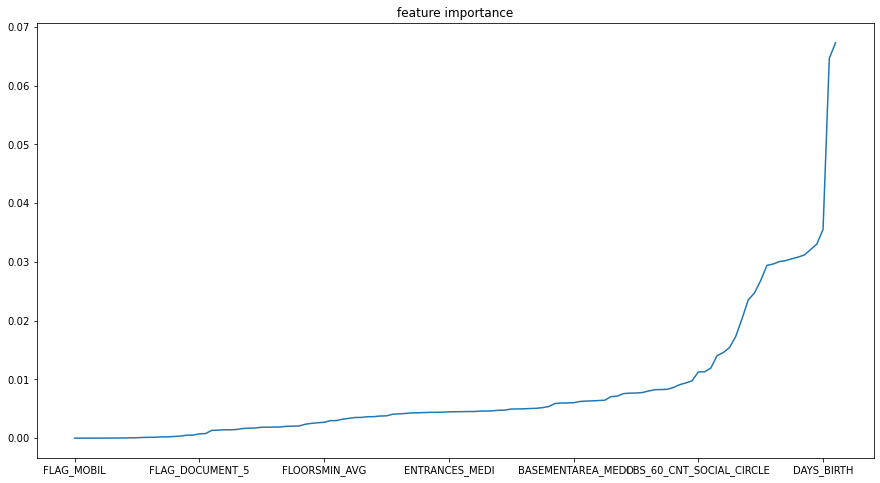

In [10]:
app_df_reduced = FeatureSelector(app_df_proc, y, id_cols=['SK_ID_CURR'], rand_cols=['rand_object', 'rand_number']).select_important_features()
inspect_df(app_df_reduced)

Neat! We reduced number of features from 122 down to 9 (not counting ID), while model score changed only slightly.

# Bureau data

Will need to perform downsampling and preprocessing for other dataframes involved as well. The key is to select only rows that link main dataframe on SK_ID_CURR column.

In [11]:
def sample_from_parent_df(parent_df, id_col, child_df):
    sample_ids = parent_df.set_index(id_col).index
    child_df = (child_df.set_index(id_col)
                .apply(lambda x: x.loc[x.index.isin(sample_ids)])
                .reset_index())
    print(f'Num ids in parent df: {len(sample_ids)}, '
          f'num ids in child df: {child_df[id_col].nunique()}')
    return child_df

In [12]:
bureau_df = sample_from_parent_df(parent_df=app_df_reduced, id_col='SK_ID_CURR', 
                                  child_df=pd.read_csv('../input/home-credit-default-risk/bureau.csv'))
inspect_df(bureau_df)

Num ids in parent df: 49650, num ids in child df: 41689
df shape: (232611, 17)
_____________________
datatypes: float64    8
int64      6
object     3
dtype: int64
_____________________
Num null vals: 549613
_____________________
_____________________


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.0,0.0,0.0,Consumer credit,-1710,NaN
1,162297,5714470,Closed,currency 1,-1146,0,-811.0,-840.0,0.0,0,103007.70,0.0,0.0,0.0,Consumer credit,-840,NaN
2,162297,5714471,Active,currency 1,-1146,0,-484.0,NaN,0.0,0,4500.00,0.0,0.0,0.0,Credit card,-690,NaN
3,162297,5714472,Active,currency 1,-1146,0,-180.0,NaN,0.0,0,337500.00,0.0,0.0,0.0,Credit card,-690,NaN
4,162297,5714473,Closed,currency 1,-2456,0,-629.0,-825.0,NaN,0,675000.00,0.0,0.0,0.0,Consumer credit,-706,NaN


Since this table has higher granularity, we cannot perform feature reduction in the same way like we did with application data and it has just 17 columns anyway, also there's no need to add random features when processing.

In [13]:
bureau_df_proc = DataPreparator(id_cols=['SK_ID_CURR', 'SK_ID_BUREAU']).prepare_data(bureau_df)
inspect_df(bureau_df_proc)

df shape: (232611, 17)
_____________________
datatypes: float32    12
int64       5
dtype: int64
_____________________
Num null vals: 0
_____________________
_____________________


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,162297,5714469,0,0,0,-1896.0,0.0,-1684.0,-1710.0,14985.0,0.0,76878.453125,0.0,0.0,0.0,-1710.0,0.0
1,162297,5714470,0,0,0,-1146.0,0.0,-811.0,-840.0,0.0,0.0,103007.703125,0.0,0.0,0.0,-840.0,0.0
2,162297,5714471,1,0,1,-1146.0,0.0,-484.0,0.0,0.0,0.0,4500.000000,0.0,0.0,0.0,-690.0,0.0
3,162297,5714472,1,0,1,-1146.0,0.0,-180.0,0.0,0.0,0.0,337500.000000,0.0,0.0,0.0,-690.0,0.0
4,162297,5714473,0,0,0,-2456.0,0.0,-629.0,-825.0,0.0,0.0,675000.000000,0.0,0.0,0.0,-706.0,0.0


## Bureau balance data

In [14]:
bureau_bal_df = sample_from_parent_df(parent_df=bureau_df_proc, id_col='SK_ID_BUREAU', 
                                      child_df=pd.read_csv('../input/home-credit-default-risk/bureau_balance.csv'))
inspect_df(bureau_bal_df)

Num ids in parent df: 232611, num ids in child df: 85663
df shape: (2224269, 3)
_____________________
datatypes: int64     2
object    1
dtype: int64
_____________________
Num null vals: 0
_____________________
_____________________


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715565,0,X
1,5715565,-1,0
2,5715565,-2,0
3,5715565,-3,X
4,5715565,-4,0


In [15]:
bureau_bal_df_proc = DataPreparator(id_cols=['SK_ID_BUREAU']).prepare_data(bureau_bal_df)
inspect_df(bureau_bal_df_proc)

df shape: (2224269, 3)
_____________________
datatypes: int64      2
float32    1
dtype: int64
_____________________
Num null vals: 0
_____________________
_____________________


,SK_ID_BUREAU,STATUS,MONTHS_BALANCE
0,5715565,0,0.0
1,5715565,1,-1.0
2,5715565,1,-2.0
3,5715565,0,-3.0
4,5715565,1,-4.0


# Feature engineering

Ok, now that data is ready, let's see what featuretools have to offer.

## Create entity set

First we need to create entity set - list all dataframes and their ids. We'll create an index for bureau balance data because it doesn't have one and it is required by featuretools.
There's an inbuilt plotting function to check entity set before proceeding.

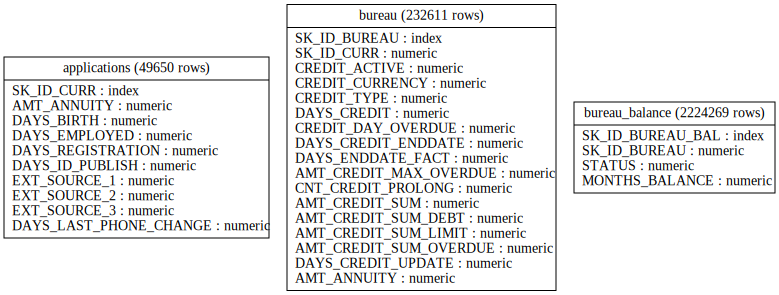

In [16]:
es = ft.EntitySet(id='credit_data')
es = es.entity_from_dataframe(entity_id='applications',
                              dataframe=app_df_reduced,
                              index='SK_ID_CURR')
es = es.entity_from_dataframe(entity_id='bureau',
                              dataframe=bureau_df_proc,
                              index='SK_ID_BUREAU')
es = es.entity_from_dataframe(entity_id='bureau_balance',
                              dataframe=bureau_bal_df_proc,
                              index='SK_ID_BUREAU_BAL',
                              make_index=True)
es.plot()

## Create relationships

Once we have our entity set, we need to establish relationships between entities (tables/dataframes).  As it was shown (see diagram in the beginning of the notebook) application data is the main table, which links to bureau data via `SK_ID_CURR` column. Each `SK_ID_CURR` can have multiple records in bureau table, which has `SK_ID_BUREAU` unique identifier that subsequently links to records in bureau_balance table.

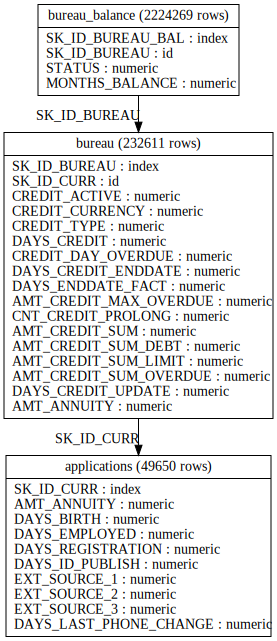

In [17]:
rel_app_bureau = ft.Relationship(parent_variable=es['applications']['SK_ID_CURR'], 
                                 child_variable=es['bureau']['SK_ID_CURR'])
rel_bureau_bal = ft.Relationship(parent_variable=es['bureau']['SK_ID_BUREAU'], 
                                 child_variable=es['bureau_balance']['SK_ID_BUREAU'])
es = es.add_relationships([rel_app_bureau, rel_bureau_bal])
es.plot()

## Create features

Automating feature creation is as simple as calling a on-liner with established entity set and pointing to a dataframe, where features should be added. Depending on data size, entity set complexity, chosen primitives, transforms and depth (see more on https://featuretools.alteryx.com/en/stable/getting_started/afe.html) this might take a while to run.

In [18]:
feat_mat, feat_def = ft.dfs(entityset=es, target_entity='applications', n_jobs=-1, max_depth=2)

EntitySet scattered to 4 workers in 10 seconds


In [19]:
inspect_df(feat_mat)

df shape: (49650, 272)
_____________________
datatypes: float32    155
float64    117
dtype: int64
_____________________
Num null vals: 5567429
_____________________
_____________________


,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,COUNT(bureau),...,SUM(bureau_balance.bureau.AMT_CREDIT_SUM_OVERDUE),SUM(bureau_balance.bureau.CNT_CREDIT_PROLONG),SUM(bureau_balance.bureau.CREDIT_ACTIVE),SUM(bureau_balance.bureau.CREDIT_CURRENCY),SUM(bureau_balance.bureau.CREDIT_DAY_OVERDUE),SUM(bureau_balance.bureau.CREDIT_TYPE),SUM(bureau_balance.bureau.DAYS_CREDIT),SUM(bureau_balance.bureau.DAYS_CREDIT_ENDDATE),SUM(bureau_balance.bureau.DAYS_CREDIT_UPDATE),SUM(bureau_balance.bureau.DAYS_ENDDATE_FACT)
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,24700.5,-9461.0,-637.0,-3648.0,-2120.0,0.083037,0.262949,0.139376,-1134.0,8.0,...,0.0,0.0,20.0,0.0,0.0,58.0,-109646.0,-40752.0,-69516.0,-72756.0
100010,42075.0,-18850.0,-449.0,-4597.0,-2379.0,0.000000,0.714279,0.540654,-1070.0,2.0,...,0.0,0.0,36.0,0.0,0.0,180.0,-139644.0,-8604.0,-41616.0,-40968.0
100017,28966.5,-14086.0,-3028.0,-643.0,-4911.0,0.000000,0.566907,0.770087,-4.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100021,13500.0,-9776.0,-191.0,-4143.0,-2427.0,0.000000,0.683513,0.000000,-2811.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100030,11074.5,-19334.0,-3494.0,-2419.0,-2893.0,0.561948,0.651406,0.461482,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Featuretools created more than 200 features out of our entity set with default primitive and transform configurations, of course not all of them make sense or add signal, so we have to perform selection again.

# Modeling

Just to see if this tool added some benefit, we'll run already introduced feature selection and see if we improved the score of benchmark model.

 ## Benchmark model

In [20]:
feat_mat.head().reset_index()

,SK_ID_CURR,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,...,SUM(bureau_balance.bureau.AMT_CREDIT_SUM_OVERDUE),SUM(bureau_balance.bureau.CNT_CREDIT_PROLONG),SUM(bureau_balance.bureau.CREDIT_ACTIVE),SUM(bureau_balance.bureau.CREDIT_CURRENCY),SUM(bureau_balance.bureau.CREDIT_DAY_OVERDUE),SUM(bureau_balance.bureau.CREDIT_TYPE),SUM(bureau_balance.bureau.DAYS_CREDIT),SUM(bureau_balance.bureau.DAYS_CREDIT_ENDDATE),SUM(bureau_balance.bureau.DAYS_CREDIT_UPDATE),SUM(bureau_balance.bureau.DAYS_ENDDATE_FACT)
0,100002,24700.5,-9461.0,-637.0,-3648.0,-2120.0,0.083037,0.262949,0.139376,-1134.0,...,0.0,0.0,20.0,0.0,0.0,58.0,-109646.0,-40752.0,-69516.0,-72756.0
1,100010,42075.0,-18850.0,-449.0,-4597.0,-2379.0,0.000000,0.714279,0.540654,-1070.0,...,0.0,0.0,36.0,0.0,0.0,180.0,-139644.0,-8604.0,-41616.0,-40968.0
2,100017,28966.5,-14086.0,-3028.0,-643.0,-4911.0,0.000000,0.566907,0.770087,-4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100021,13500.0,-9776.0,-191.0,-4143.0,-2427.0,0.000000,0.683513,0.000000,-2811.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100030,11074.5,-19334.0,-3494.0,-2419.0,-2893.0,0.561948,0.651406,0.461482,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
feat_mat_proc = DataPreparator(id_cols=['SK_ID_CURR'], add_rand_cols=True).prepare_data(feat_mat.reset_index())
inspect_df(feat_mat_proc)

df shape: (49650, 274)
_____________________
datatypes: float32    272
int64        1
float64      1
dtype: int64
_____________________
Num null vals: 0
_____________________
_____________________


,SK_ID_CURR,AMT_ANNUITY,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,...,SUM(bureau_balance.bureau.CNT_CREDIT_PROLONG),SUM(bureau_balance.bureau.CREDIT_ACTIVE),SUM(bureau_balance.bureau.CREDIT_CURRENCY),SUM(bureau_balance.bureau.CREDIT_DAY_OVERDUE),SUM(bureau_balance.bureau.CREDIT_TYPE),SUM(bureau_balance.bureau.DAYS_CREDIT),SUM(bureau_balance.bureau.DAYS_CREDIT_ENDDATE),SUM(bureau_balance.bureau.DAYS_CREDIT_UPDATE),SUM(bureau_balance.bureau.DAYS_ENDDATE_FACT),rand_number
0,100002,24700.5,-9461.0,-637.0,-3648.0,-2120.0,0.083037,0.262949,0.139376,-1134.0,...,0.0,20.0,0.0,0.0,58.0,-109646.0,-40752.0,-69516.0,-72756.0,0.374540
1,100010,42075.0,-18850.0,-449.0,-4597.0,-2379.0,0.000000,0.714279,0.540654,-1070.0,...,0.0,36.0,0.0,0.0,180.0,-139644.0,-8604.0,-41616.0,-40968.0,0.950714
2,100017,28966.5,-14086.0,-3028.0,-643.0,-4911.0,0.000000,0.566907,0.770087,-4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.731994
3,100021,13500.0,-9776.0,-191.0,-4143.0,-2427.0,0.000000,0.683513,0.000000,-2811.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.598658
4,100030,11074.5,-19334.0,-3494.0,-2419.0,-2893.0,0.561948,0.651406,0.461482,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156019


Model score with full feature set 0.6526888217522658
Number of features with greater than random column importance 8
Model score with reduced feature set 0.6556294058408862


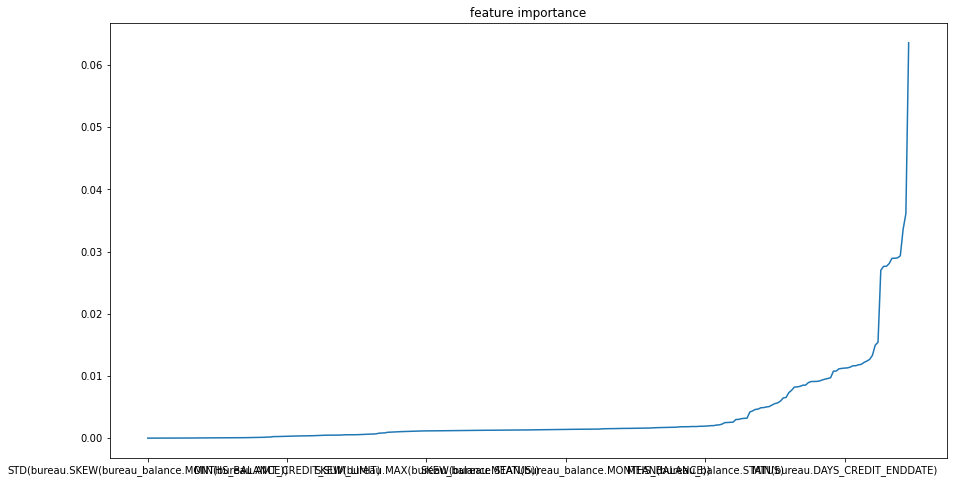

In [22]:
feat_mat_imp = FeatureSelector(feat_mat_proc, y, id_cols=['SK_ID_CURR'], rand_cols=['rand_object', 'rand_number']).select_important_features()

# Conclusion

Added features didn't seem to improve the score pre and post selection by importance. This of course does not mean that the tool is useless, because most of the time feature engineering is just adding the same basic primitives and transforms - counts, sums, means, etc. Remember, we have not considered all tables available in the data, perhaps they contain more signal. Also, featuretools were run with default presets, which could be tinkered with, so definitely looks like something to add in the toolset, to inrease productivity, especially when building PoCs.